In [72]:
import cv2
import mediapipe as mp
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import math
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16
from keras.applications import inception_v3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, Input
from tensorflow.keras.callbacks import TensorBoard

In [2]:
mpsolution = mp.solutions.holistic
drawing = mp.solutions.drawing_utils

In [3]:
def Superimpose(image, landmarks):
    drawing.draw_landmarks(image, landmarks.face_landmarks, mpsolution.FACEMESH_CONTOURS, drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1), drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    drawing.draw_landmarks(image, landmarks.pose_landmarks, mpsolution.POSE_CONNECTIONS)
    drawing.draw_landmarks(image, landmarks.left_hand_landmarks, mpsolution.HAND_CONNECTIONS, drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1), drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))
    drawing.draw_landmarks(image, landmarks.right_hand_landmarks, mpsolution.HAND_CONNECTIONS, drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1), drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

In [4]:
def BrightnessContrast(img, brightness = 0, contrast = 0):
     
    # getTrackbarPos returns the current
    # position of the specified trackbar.
    # brightness = cv2.getTrackbarPos('Brightness', 'test')
      
    # contrast = cv2.getTrackbarPos('Contrast', 'test')
  
    effect = controller(img, brightness, contrast)
  
    # The function imshow displays an image
    # in the specified window
    return effect

def controller(img, brightness=255, contrast=127):
    brightness = int((brightness - 0) * (255 - (-255)) / (510 - 0) + (-255))
    contrast = int((contrast - 0) * (127 - (-127)) / (254 - 0) + (-127))
  
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            max = 255
        else:
            shadow = 0
            max = 255 + brightness

        al_pha = (max - shadow) / 255
        ga_mma = shadow
  
        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(img, al_pha, img, 0, ga_mma)
    else:
        cal = img
  
    if contrast != 0:
        Alpha = float(131 * (contrast + 127)) / (127 * (131 - contrast))
        Gamma = 127 * (1 - Alpha)  
        # The function addWeighted calculates
        # the weighted sum of two arrays
        cal = cv2.addWeighted(cal, Alpha, cal, 0, Gamma)
  
    # putText renders the specified text string in the image.
    #cv2.putText(cal, 'B:{},C:{}'.format(brightness, contrast), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
  
    return cal

In [5]:
def detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    result = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return result

In [6]:
def ProcessPaper(video):
    processed = dict()
    final = []

    for frame in range(len(video)):
        ft = []
        if not video[frame].pose_landmarks:
            ft = np.zeros((1056, 3), float)
        else:
            for feature in range(len(video[frame].pose_landmarks.landmark)):
                for feature2 in range (len(video[frame].pose_landmarks.landmark)):
                    if feature2 == feature:
                        continue

                    ptref = video[frame].pose_landmarks.landmark[feature2]
                    pt = video[frame].pose_landmarks.landmark[feature]

                    deltax = math.sqrt((pt.y - ptref.y)**2 + (pt.z - ptref.z)**2)
                    deltay = math.sqrt((pt.x - ptref.x)**2 + (pt.z - ptref.z)**2)
                    deltaz = math.sqrt((pt.y - ptref.y)**2 + (pt.x - ptref.x)**2)
                    delta = [deltax, deltay, deltaz]

                    # lamdax = math.sqrt((pt.y - pt2.y)**2 + (pt.z - pt2.z)**2)
                    # lamday = math.sqrt((pt.x - pt2.x)**2 + (pt.z - pt2.z)**2)
                    # lamdaz = math.sqrt((pt.y - pt2.y)**2 + (pt.x - pt2.x)**2)
                    # lamda = [lamdax, lamday, lamdaz]

                    # largest = max(lamda + delta)
                    # smallest = min(lamda + delta)

                    largest = max(delta)
                    smallest = min(delta)

                    for temp in range(len(delta)):
                        # lamda[temp] = ((lamda[temp] - smallest)/(largest - smallest))
                        delta[temp] = ((delta[temp] - smallest)/(largest - smallest))

                    ft.append(delta)
            final.append(ft)
    return np.array(final)

In [7]:
def Process(result):
    processed = dict()

    if result.pose_landmarks:
        # temp = list(result.pose_landmarks.landmark)[0]
        # landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z), res.visibility] for res in result.pose_landmarks.landmark])
        landmarks = np.array([[(res.x), (res.y), (res.z), res.visibility] for res in result.pose_landmarks.landmark])
    else:
        landmarks = np.zeros(33*4)

    processed["pose"] = landmarks.flatten()

    if result.face_landmarks:
        #temp = list(result.face_landmarks.landmark)[0]
        # landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z)] for res in result.face_landmarks.landmark])
        landmarks = np.array([[(res.x), (res.y), (res.z)] for res in result.face_landmarks.landmark])
    else:
        landmarks = np.zeros(468*3)

    processed["face"] = landmarks.flatten()

    if result.right_hand_landmarks:
        #temp = list(result.right_hand_landmarks.landmark)[0]
        # landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z)] for res in result.right_hand_landmarks.landmark])
        landmarks = np.array([[(res.x), (res.y), (res.z)] for res in result.right_hand_landmarks.landmark])
    else:
        landmarks = np.zeros(21*3)

    processed["right_hand"] = landmarks.flatten()

    if result.left_hand_landmarks:
        #temp = list(result.left_hand_landmarks.landmark)[0]
        # landmarks = np.array([[(res.x - temp.x), (res.y - temp.y), (res.z - temp.z)] for res in result.left_hand_landmarks.landmark])
        landmarks = np.array([[(res.x), (res.y), (res.z)] for res in result.left_hand_landmarks.landmark])
    else:
        landmarks = np.zeros(21*3)

    processed["left_hand"] = landmarks.flatten()

    #return processed
    return np.concatenate([processed["pose"], processed["face"], processed["left_hand"], processed["right_hand"]])
    # return processed["pose"]

In [8]:
def DataCollection(path, frames, videos, actions):
    cap = cv2.VideoCapture(0)
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    for action in actions:
        os.makedirs(os.path.join(path, action))

        for video in range(videos):
            out = cv2.VideoWriter(os.path.join(path, action, "vid%s.avi"%video), fourcc, 25, (640, 480))

            for frame in range(frames):
                ret, image = cap.read()

                if not ret:
                    print(os.path.join(path, action, "vid%s.avi"%video))
                    break

                effect = BrightnessContrast(image, 357, 209)

                if frame == 0:
                    cv2.putText(effect, "Starting Collection", (120, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                    cv2.waitKey(2500)
                
                cv2.putText(effect, "Collecting frames for {} video number {}".format(action, video), (15, 12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)

                out.write(effect)

                cv2.imshow("OnlyFans!!", effect)

                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break

    cap.release()
    cv2.destroyAllWindows()

In [9]:
def run(path):
    data = []
    video = cv2.VideoCapture(path)
    # cv2.namedWindow('test')
    # cv2.createTrackbar('Brightness', 'test', 255, 2 * 255, BrightnessContrast) 
    # cv2.createTrackbar('Contrast', 'test', 127, 2 * 127, BrightnessContrast)
    
    with mpsolution.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5) as model:
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                print(path)
                break
        
            result1 = detection(frame, model)
           # effect = BrightnessContrast(frame, 357, 209)
            #result2 = detection(effect, model)

            Superimpose(frame, result1)
            #Superimpose(effect, result2)
        
            cv2.imshow("OnlyFans!!", frame)
            #cv2.imshow("effect", effect)
            data.append(result1)
            # np.save(save + "/" + str(count), final)

            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
    
        video.release()
        cv2.destroyAllWindows()
        return data

video = cv2.VideoCapture(0)
# cv2.namedWindow('test')
# cv2.createTrackbar('Brightness', 'test', 255, 2 * 255, BrightnessContrast) 
# cv2.createTrackbar('Contrast', 'test', 127, 2 * 127, BrightnessContrast)
    
with mpsolution.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5) as model:
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        # result1 = detection(frame, model)
        effect = BrightnessContrast(frame, 357, 209)
        # result2 = detection(effect, model)

        #Superimpose(frame, result1)
        # Superimpose(effect, result2)
        
        cv2.imshow("OnlyFans!!", frame)
        cv2.imshow("effect", effect)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    video.release()
    cv2.destroyAllWindows()

In [10]:
with open("missing.txt") as f:
    missing = f.readlines()
    missing = [temp.rstrip("\n") for temp in missing]
    
with open("exercise.json") as f:
    temp = json.load(f)
    data = dict()
    count = 0
    for i in range(len(temp)):
        temp2 = temp[i]["instances"].copy()
        for x in temp[i]["instances"]:
            if missing.count(x["video_id"]) > 0:
                temp2.remove(x)
                count += 1
        data[temp[i]["gloss"]] = [(temp3["video_id"], temp3["frame_start"], temp3["frame_end"]) for temp3 in temp2]


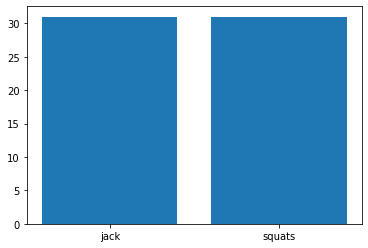

In [11]:
data.keys()
actions = {temp : data[temp] for temp in data}
plt.bar(list(actions.keys()), list(len(temp) for temp in actions.values()), align='center')
plt.xticks(range(len(actions)), list(actions.keys()))

plt.show()


data = run("C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0043.mp4")
final = ProcessPaper(data)

final.shape

plt.imshow(final, interpolation='nearest')
plt.show()

In [12]:
for action in actions:
    os.mkdir("videos/%s"%action)
    for instance in actions[action]:
        data = run("C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/%s.mp4"%instance[0])
        final = ProcessPaper(data)
        np.save("videos/%s/%s"%(action, instance[0]), final)

C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0000.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0001.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0002.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0003.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0004.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0005.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0006.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0007.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0008.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0009.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0010.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0011.mp4
C:/Users/kevin/OneDrive/Documents/Year4/ECNG3020/Code/data/videos/0012.mp4
C:/Users/kevin/OneDrive/D

In [13]:
# DataCollection("C:\\Users\\kevin\\OneDrive\\Documents\\Year4\\ECNG3020\\Code\\data\\myvids", 60, 30, ["jack", "squats"])

In [14]:
for action in actions:
    for filename in os.listdir("C:\\Users\\kevin\\OneDrive\\Documents\\Year4\\ECNG3020\\Code\\data\\myvids\\%s"%action):
        path = os.path.join("C:\\Users\\kevin\\OneDrive\\Documents\\Year4\\ECNG3020\\Code\\data\\myvids\\%s"%action, filename)
        data = run(path)
        final = ProcessPaper(data)
        np.save("videos/%s/%s"%(action, filename[:-4]), final)
    

C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid1.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid10.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid11.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid12.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid13.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid14.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid15.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid16.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid17.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid18.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid19.avi
C:\Users\kevin\OneDrive\Documents\Year4\ECNG3020\Code\data\myvids\jack\vid2.avi
C:\Users\kevin\OneDrive\Docume

In [12]:
label_map = {label: num for num, label in enumerate(actions)}
label_map

{'jack': 0, 'squats': 1}

In [13]:
count = 0
for action in actions:
    for video in os.listdir("videos/%s"%action):
        count += 1
print(count)


120


In [14]:
sequences, labels = [], []
for action in actions:
    for video in os.listdir("videos/%s"%action):
        temp = []
        vid = np.load("videos/%s/%s"%(action, video),)
        print(vid.shape)
        sequences.append(vid)
        labels.append(label_map[action])


(57, 1056, 3)
(27, 1056, 3)
(26, 1056, 3)
(30, 1056, 3)
(27, 1056, 3)
(40, 1056, 3)
(36, 1056, 3)
(26, 1056, 3)
(27, 1056, 3)
(43, 1056, 3)
(27, 1056, 3)
(27, 1056, 3)
(32, 1056, 3)
(26, 1056, 3)
(22, 1056, 3)
(22, 1056, 3)
(22, 1056, 3)
(36, 1056, 3)
(22, 1056, 3)
(31, 1056, 3)
(24, 1056, 3)
(30, 1056, 3)
(33, 1056, 3)
(31, 1056, 3)
(31, 1056, 3)
(13, 1056, 3)
(28, 1056, 3)
(26, 1056, 3)
(23, 1056, 3)
(21, 1056, 3)
(11, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(59, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(60, 1056, 3)
(111, 1056, 3)
(91, 1056, 3)
(121, 1056, 3)
(109, 1056, 3)
(97, 1056, 3)
(103, 1056, 3)
(122, 1056, 3)
(64, 1056, 3)
(47, 1056, 3)
(38, 1056, 3)
(50, 1056, 3)
(

sequences, labels = [], []
for action in actions:
    for video in os.listdir("videos/%s"%action):
        temp = []
        for filename in os.listdir("videos/%s/%s"%(action, video)):
            frame = np.load("videos/%s/%s/%s"%(action, video, filename))
            if len(frame) != 33*4:
                print("ERROR IN videos/%s/%s/%s"%(action, video, filename))
            temp.append(frame)
        sequences.append(temp)
        labels.append(label_map[action])


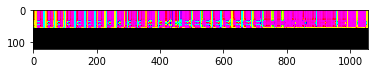

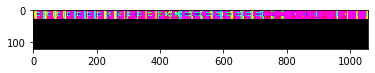

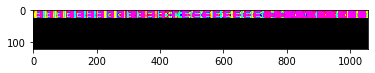

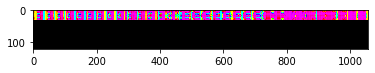

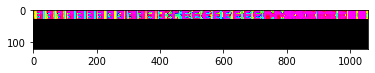

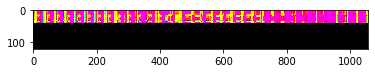

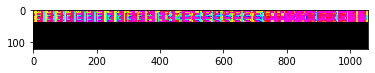

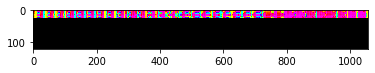

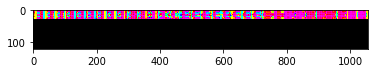

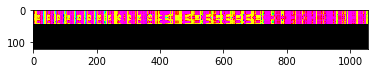

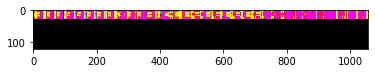

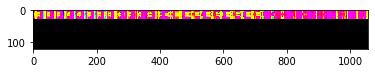

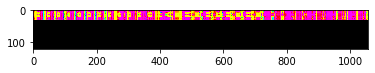

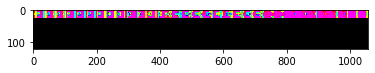

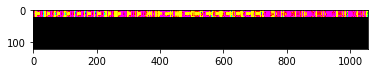

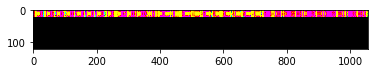

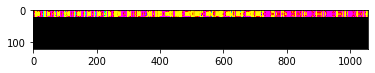

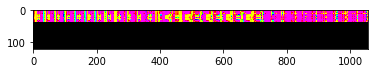

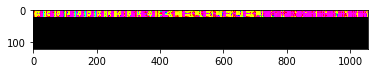

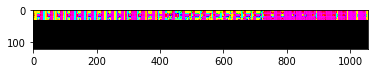

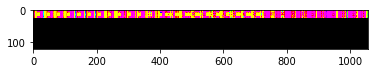

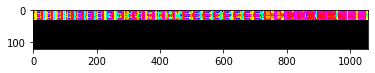

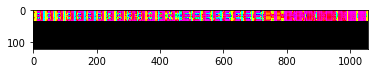

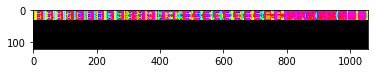

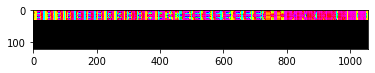

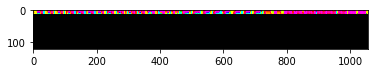

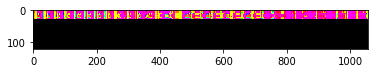

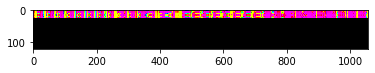

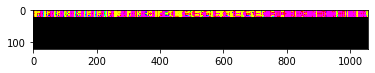

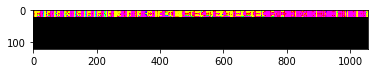

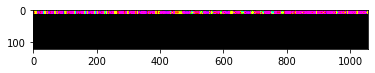

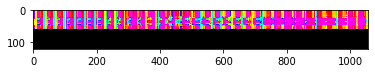

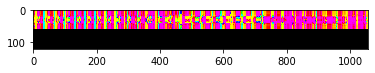

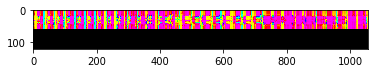

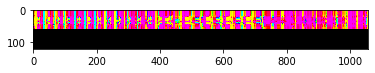

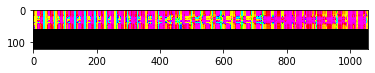

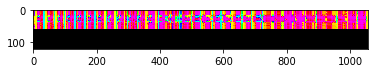

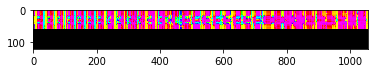

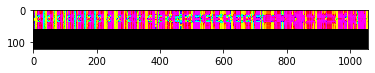

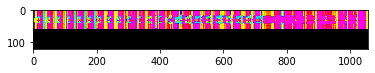

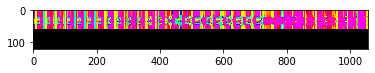

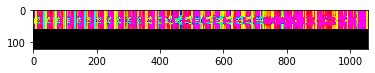

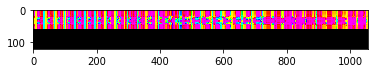

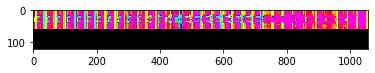

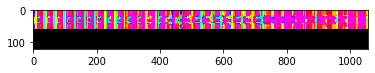

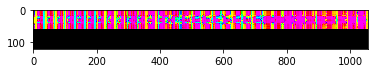

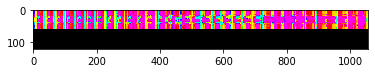

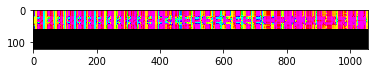

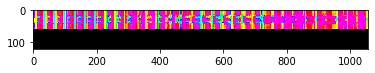

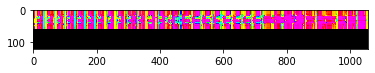

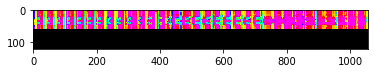

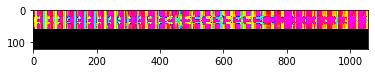

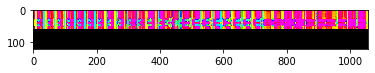

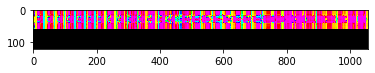

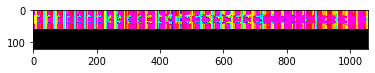

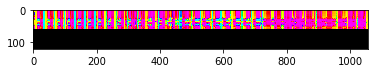

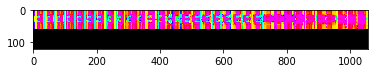

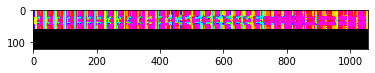

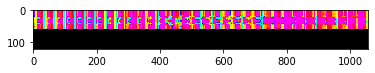

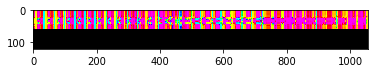

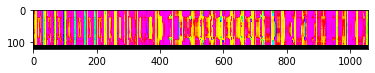

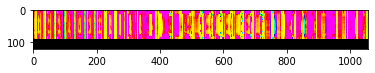

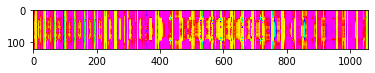

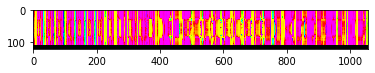

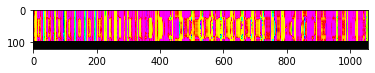

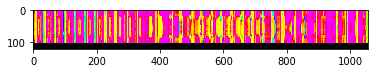

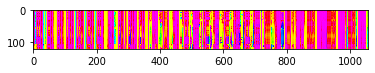

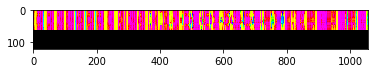

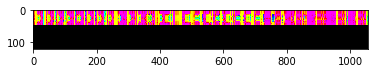

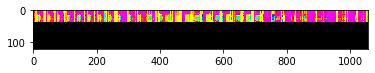

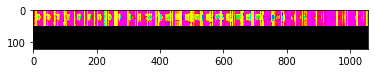

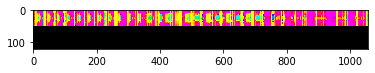

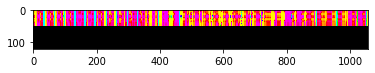

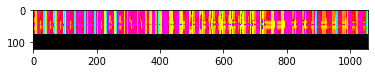

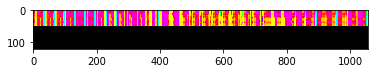

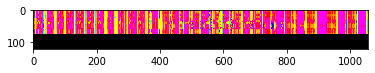

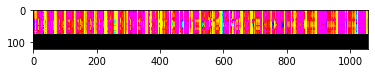

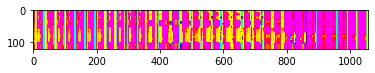

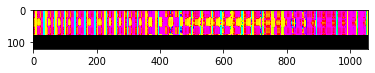

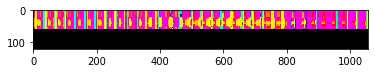

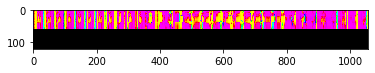

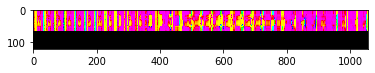

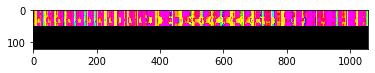

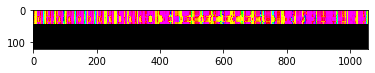

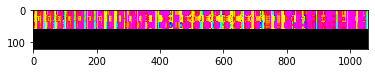

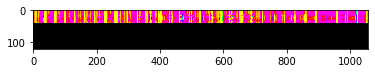

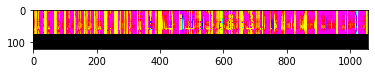

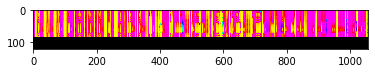

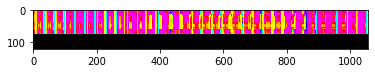

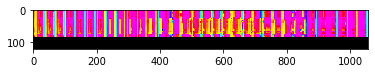

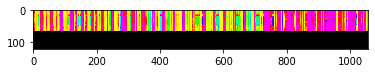

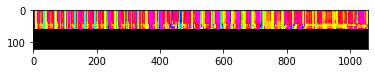

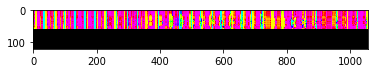

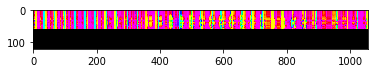

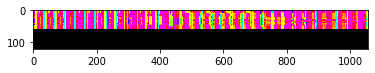

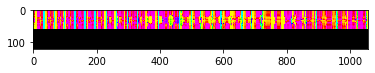

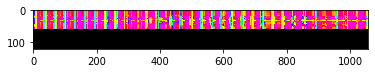

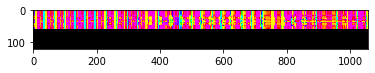

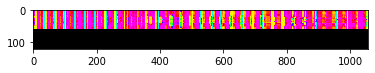

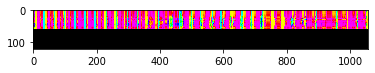

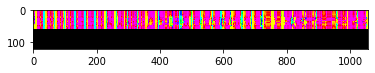

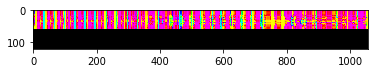

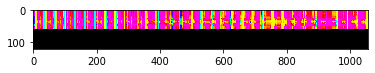

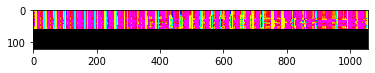

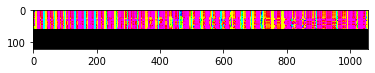

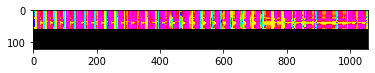

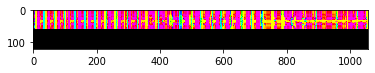

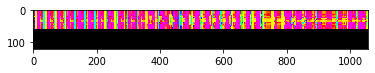

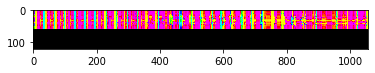

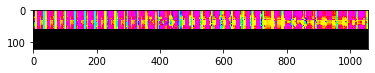

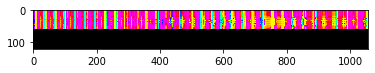

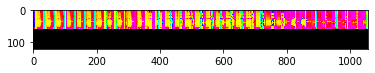

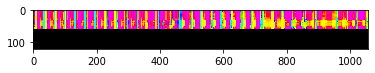

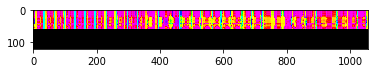

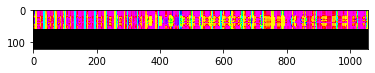

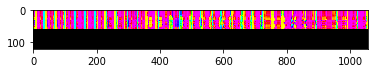

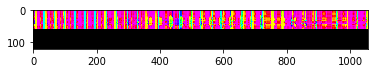

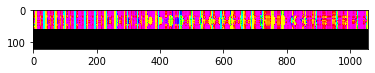

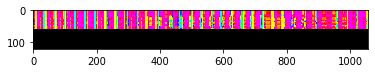

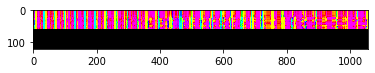

In [28]:
x = []
full = max([len(i) for i in sequences])
for vid in sequences:
    temp = np.copy(vid)
    if len(vid) < full:
        for i in range(full - len(vid)):
            temp = np.append(temp, np.zeros((1056, 3), float))
    temp = np.reshape(temp, (full, 1056, 3))
    plt.imshow(temp, interpolation='nearest')
    plt.show()
    temp2 = inception_v3.preprocess_input(temp)
    x.append(temp2)


In [29]:
x = np.array(x)
y = to_categorical(labels).astype(int)

In [88]:
y.shape

(120, 2)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05)

In [32]:
x_train[0].shape

(122, 1056, 3)

In [33]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [93]:
model2 = Sequential()
model2.add(inception_v3.InceptionV3(include_top=False, weights='imagenet', input_tensor=Input(shape=(122, 1056, 3)), pooling='avg', classifier_activation='softmax'))
for layer in model2.layers:
    layer.trainable = False
model2.add(Dense(128, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(2, activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model1 = Sequential()
model1.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30, 1662)))
model1.add(LSTM(128, return_sequences=True, activation='relu'))
model1.add(LSTM(64, return_sequences=False, activation='relu'))
model1.add(Dense(64, activation='relu'))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(3, activation='softmax'))
model1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [94]:
model2.fit(x_train, y_train, epochs=350, callbacks=[tb_callback])

Epoch 1/350
4/4 [==============================] - 15s 1s/step - loss: 0.6409 - categorical_accuracy: 0.6491
Epoch 2/350
4/4 [==============================] - 2s 370ms/step - loss: 0.4809 - categorical_accuracy: 0.8158
Epoch 3/350
4/4 [==============================] - 1s 358ms/step - loss: 0.3050 - categorical_accuracy: 0.9123
Epoch 4/350
4/4 [==============================] - 1s 358ms/step - loss: 0.1760 - categorical_accuracy: 0.9649
Epoch 5/350
4/4 [==============================] - 1s 362ms/step - loss: 0.1345 - categorical_accuracy: 0.9649
Epoch 6/350
4/4 [==============================] - 2s 365ms/step - loss: 0.1177 - categorical_accuracy: 0.9649
Epoch 7/350
4/4 [==============================] - 1s 358ms/step - loss: 0.0548 - categorical_accuracy: 0.9912
Epoch 8/350
4/4 [==============================] - 2s 368ms/step - loss: 0.0514 - categorical_accuracy: 0.9912
Epoch 9/350
4/4 [==============================] - 1s 354ms/step - loss: 0.0397 - categorical_accuracy: 0.9912
Epo

KeyboardInterrupt: 

In [95]:
sequence = []
sentence = []
res = []
threshold = 0.4

video = cv2.VideoCapture(0)
# cv2.namedWindow('test')
# cv2.createTrackbar('Brightness', 'test', 255, 2 * 255, BrightnessContrast) 
# cv2.createTrackbar('Contrast', 'test', 127, 2 * 127, BrightnessContrast)
    
with mpsolution.Holistic(min_detection_confidence = 0.5, min_tracking_confidence=0.5) as model:
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        
        effect = BrightnessContrast(frame, 357, 209)
        result2 = detection(effect, model)
        Superimpose(effect, result2)

        pose = ProcessPaper(result2)
        sequence.insert(0, pose)
        sequence = sequence[:122]

        if len(sequence) == 122:
            res = model2.predict(np.expand_dims(sequence, axis=0))[0]

            if res[np.argmax(res)] > threshold:
                print(actions[np.argmax(res)])
                if len(sentence) > 0:
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

                if len(sentence) > 5:
                    sentence = sentence[-5:]

        cv2.rectangle(effect, (0, 0), (640, 40), (245, 117, 16), -1,)
        cv2.putText(effect, ' '.join(sentence), (3, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow("effect", effect)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    video.release()
    cv2.destroyAllWindows()

ValueError: in user code:

    File "C:\Users\kevin\miniconda3\envs\ECNG3020\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\kevin\miniconda3\envs\ECNG3020\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\kevin\miniconda3\envs\ECNG3020\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\kevin\miniconda3\envs\ECNG3020\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\kevin\miniconda3\envs\ECNG3020\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\kevin\miniconda3\envs\ECNG3020\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_31" is incompatible with the layer: expected shape=(None, 122, 1056, 3), found shape=(None, 122, 1662)
